In [260]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [261]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from moabb.datasets import BI2013a

from power import field_root_mean_square, plot_fmrs
from data_processing import get_clean_epochs, SpatialFilter

In [262]:
dataset=BI2013a()
dataset.subject_list

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [263]:
epochs = get_clean_epochs(dataset)

Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns


/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data loaded,
 'Target': 80
 'NonTarget': 400>
  warn(f"warnEpochs {epochs}")
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data loaded,
 'Target': 80
 'NonTarget': 400>
  warn(f"warnEpochs {epochs}")
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data loaded,
 'Target': 80
 'NonTarget': 400>
  warn(f"warnEpochs {epochs}")
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data 

Adding metadata with 3 columns
3360 matching events found
No baseline correction applied
Dataset median value:  -2.277286300659693e-07
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F5', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejec

In [264]:
epochs

<EpochsArray | 2234 events (all good), 0 – 1 s (baseline off), ~139.9 MB, data loaded, with metadata,
 'Target': 221
 'NonTarget': 2013>

In [371]:
import math
import copy
from scipy.signal import argrelextrema


def initialize_weights(class_epochs):
    weights = [1/np.linalg.norm(e_i) for e_i in class_epochs] #1/Frobenius_norm
    weights = weights/sum(weights) #normalize
    return weights

# apply weights in epochs before calculating filter

def compute_weights(class_epochs, A_p, B_p):
    """
    Calculates set of weights for epochs from a given class
        class_epochs: epochs from a given class
        A_p,B_p: spatial filters
    Returns: list of weights of len(class_epochs)
    """
    weights = [np.linalg.norm(A_p@B_p@e_i) - np.linalg.norm(A_p@B_p@e_i) for e_i in class_epochs]
    weights = weights/sum(weights)
    return weights

def improved_compute_weights(class_epochs, spatial_filter):
    """
    Calculates set of weights for epochs from a given class
        class_epochs: epochs from a given class
        spatial_filter: fitted spatial filter
    Returns: list of weights of len(class_epochs)
    """
    class_epochs_sf = spatial_filter.apply(class_epochs)
    weights = [np.linalg.norm(e_sf_i) - np.linalg.norm(e_i - e_sf_i) for e_sf_i, e_i in zip(class_epochs_sf,class_epochs)]
    weights = weights/sum(weights)
    return weights

def find_local_max_idx(array, n_smooth=3):
    """
    Find indexes of local maxima values respecting that each local maxima is >= 66% of global maxima
    Returns: indexes of local maxima
    """
    #smooth by averaging with n_neigh neighbour points
    # smoothed_array = np.convolve(array, np.ones(n_smooth)/n_smooth, mode='same')
    smoothed_array=array
    # print(smoothed_array)
    max_idx = argrelextrema(smoothed_array, np.greater)
    # print("max_idx ",max_idx)
    #get valid idx i.e. local max >= 66% of max
    valid_idx = np.where(smoothed_array>=0.66%np.max(smoothed_array))[0]
    #get valid local extrema idx
    valid_local_max_idx = np.flatnonzero(np.isin(max_idx, valid_idx))
    return valid_local_max_idx

def lagged_epochs(epoch, E):
    """
        For a given epoch, creates list of lagged versions of it of len=2*E+1. Creates central sample [E:-E] and 2*E lagged versions around it
        Returns: list of lagged epochs
    """
    lagged_e_is=[]
    for eps in range(2*E+1):
        e_i = copy.deepcopy(epoch)
        e_i.crop(tmin=e_i.times[eps], tmax = e_i.times[len(e_i.times)+eps-2*E-1], include_tmax=True)
        lagged_e_is.append(e_i)
        del e_i
    return lagged_e_is
    

def compute_lags(class_epochs):
    """
    Compute, for each epoch, the lag that amounts to the highest covariance between each epoch and the exclusive epochs average
    Returns: list of lags of len(class_epochs)
    """
    
    sfreq = class_epochs.info['sfreq'] #sampling frequency
    # E = math.floor(40*1e-3*sfreq) #Maximum allowed time-shift in samples unit. It should correspond to something around and less than 40ms 
    E = 3
    max_num_it = 2*E
    class_epochs_cropped = copy.deepcopy(class_epochs).crop(tmin=class_epochs.times[E], tmax = class_epochs.times[-E-1], include_tmax=True) #will only look to an epoch in window interval so we can use border values to compute the lag
    print("len class_epochs_cropped",len(class_epochs_cropped))
    for i, e_i in enumerate(class_epochs_cropped.iter_evoked()):
        print(e_i.get_data()[0].shape)
        print(e_i.get_data()[0])
        plt.figure()
        plt.scatter(e_i.times,e_i.get_data()[0])

    cond = E-1
    epochs_idx = np.arange(len(class_epochs_cropped))
    cond_hist = []
    num_it = 0


    while cond < E and num_it < max_num_it:
        lags_list=[]
        for i, e_i in enumerate (class_epochs.iter_evoked()):
            
            #(filtered and weighted) ensemble average excluding the current epoch/sweep
            avg_epochs_m1 = class_epochs_cropped[np.where(epochs_idx!= i)[0]].average(picks="all").get_data()
            #set of (filtered and weighted) single lagged i epoch estimation, for all lags
            lagged_e_is = lagged_epochs(e_i, E) #lags between -E and +E
            covs = np.array([np.matrix.trace(l_ei.get_data()@avg_epochs_m1.T) for l_ei in lagged_e_is])
            lm_idx = find_local_max_idx(covs)
            lm_idx = lm_idx - E #reset reference. Sample [E:-E] corresponds to lag=0, sample [0:len(e_i)-2E] has lag =-E etc.
            if lm_idx.size>0:
                lags_list.append(min(lm_idx)) #get smallest index (corresponds to smallest lag)
            else:
                lags_list.append(0) #if there is no local max, the lag is 0
        cond = sum(lags_list)
        cond_hist.append(cond)
        num_it+=1
        print(num_it)
        
    return lags_list, cond_hist

In [268]:
epochs["Target"]

<EpochsArray | 221 events (all good), 0 – 1 s (baseline off), ~13.9 MB, data loaded, with metadata,
 'Target': 221>

In [354]:
epochs_.get_data(), E

(array([[[ 1.,  2.,  5.,  8.,  7.,  9.,  2.,  2., 10.]],
 
        [[ 5.,  8.,  7.,  9.,  2.,  2., 10., 20., 30.]],
 
        [[ 1.,  2.,  5.,  8.,  7.,  9.,  2.,  2., 10.]]]),
 2)

In [358]:
epochs_.times, epochs_.times[-E-1]

(array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889]),
 0.6666666666666666)

In [366]:
class_epochs_cropped = copy.deepcopy(epochs_).crop(tmin=epochs_.times[E], tmax = epochs_.times[-E-1], include_tmax=True)
class_epochs_cropped.get_data()

array([[[ 5.,  8.,  7.,  9.,  2.]],

       [[ 7.,  9.,  2.,  2., 10.]],

       [[ 5.,  8.,  7.,  9.,  2.]]])

In [373]:
# %%time
# lags_list, cond_hist = compute_lags(epochs["Target"])
# lags_list

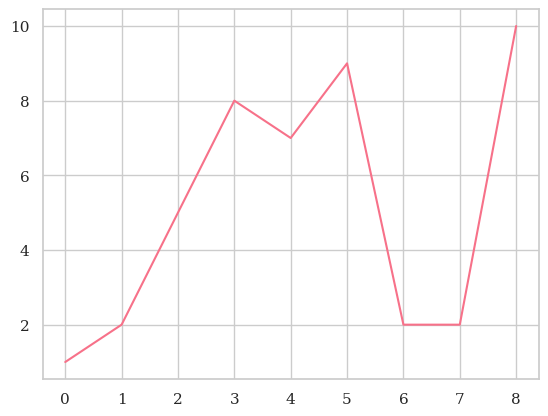

In [348]:
a = np.array([1,2,5,8,7,9,2,2,10])
find_local_max_idx(a)
plt.plot(a)

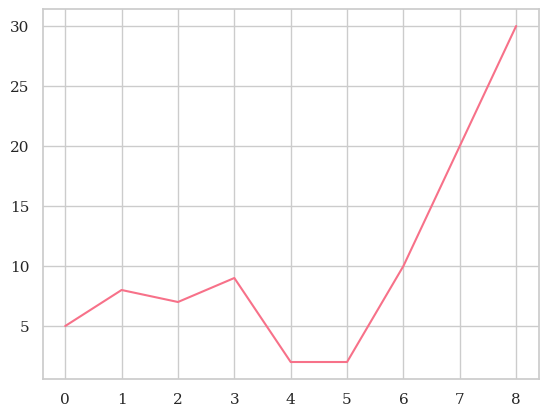

In [349]:
b = np.array([5,8,7,9,2,2,10,20,30])
plt.plot(b)

In [350]:
e_ = np.stack([np.expand_dims(a, axis=0), np.expand_dims(b, axis=0), np.expand_dims(a, axis=0)])
e_.shape, e_

((3, 1, 9),
 array([[[ 1,  2,  5,  8,  7,  9,  2,  2, 10]],
 
        [[ 5,  8,  7,  9,  2,  2, 10, 20, 30]],
 
        [[ 1,  2,  5,  8,  7,  9,  2,  2, 10]]]))

In [351]:
info_ = mne.create_info(1,9)
epochs_ = mne.EpochsArray(e_,info_)

Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated


In [370]:
lags_list

[-2, 0, -2]

len class_epochs_cropped 3
(3,)
[8. 7. 9.]
(3,)
[9. 2. 2.]
(3,)
[8. 7. 9.]
1
2
3
4
5
6


[-3, -3, -3]

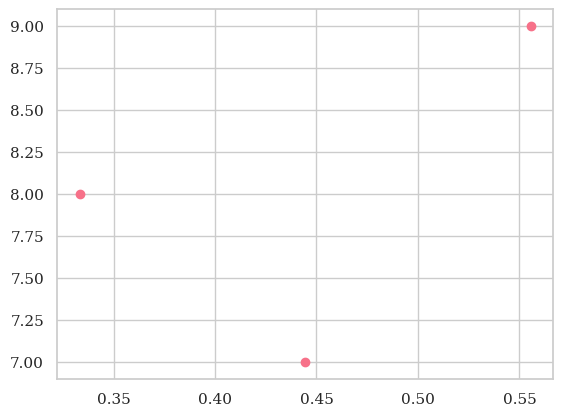

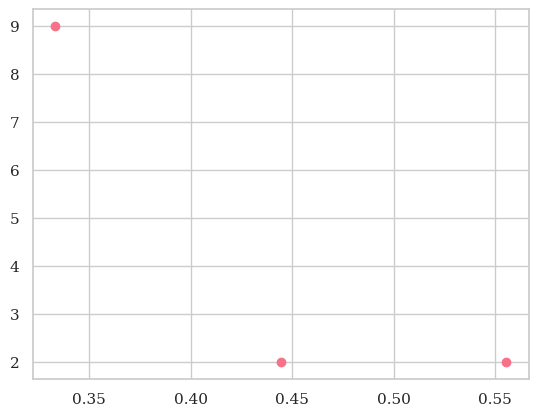

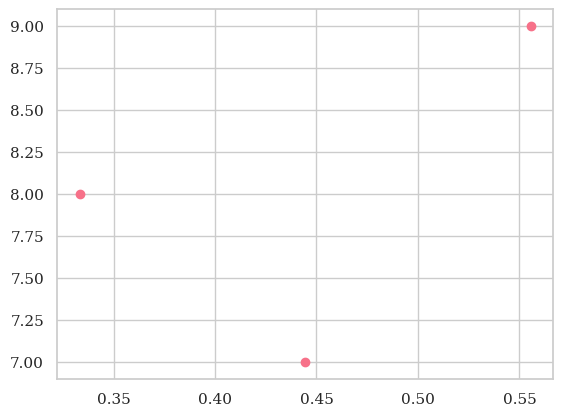

In [372]:
lags_list, cond_hist = compute_lags(epochs_)
lags_list

In [304]:
epochs_.info['sfreq']

9.0

In [202]:
E, len(e_i.times)

(2, 497)

In [203]:
for i, e_i in enumerate (epochs["Target"].iter_evoked()):
    for eps in range(2*E+1):
        print("E",E)
        print("len(e_i.times)",len(e_i.times))
        print("e_i.times", e_i.times)
        print("idx = eps", eps)
        print("e_i.times[eps]", e_i.times[eps])
        print("idx = len(e_i.times)+eps-2*E", len(e_i.times)+eps-2*E)
        print("e_i.times[len(e_i.times)+eps-2*E]",e_i.times[len(e_i.times)+eps-2*E])
        e_i.crop(tmin=e_i.times[eps], tmax = e_i.times[len(e_i.times)+eps-2*E], include_tmax=False)
    break

E 2
len(e_i.times) 513
e_i.times [0.         0.00195312 0.00390625 0.00585938 0.0078125  0.00976562
 0.01171875 0.01367188 0.015625   0.01757812 0.01953125 0.02148438
 0.0234375  0.02539062 0.02734375 0.02929688 0.03125    0.03320312
 0.03515625 0.03710938 0.0390625  0.04101562 0.04296875 0.04492188
 0.046875   0.04882812 0.05078125 0.05273438 0.0546875  0.05664062
 0.05859375 0.06054688 0.0625     0.06445312 0.06640625 0.06835938
 0.0703125  0.07226562 0.07421875 0.07617188 0.078125   0.08007812
 0.08203125 0.08398438 0.0859375  0.08789062 0.08984375 0.09179688
 0.09375    0.09570312 0.09765625 0.09960938 0.1015625  0.10351562
 0.10546875 0.10742188 0.109375   0.11132812 0.11328125 0.11523438
 0.1171875  0.11914062 0.12109375 0.12304688 0.125      0.12695312
 0.12890625 0.13085938 0.1328125  0.13476562 0.13671875 0.13867188
 0.140625   0.14257812 0.14453125 0.14648438 0.1484375  0.15039062
 0.15234375 0.15429688 0.15625    0.15820312 0.16015625 0.16210938
 0.1640625  0.16601562 0.1679

IndexError: index 497 is out of bounds for axis 0 with size 497

In [193]:
a = np.arange(10)
E = 2
for eps in range(2*E+1):
    print("eps", eps)
    print("-2*E+eps",len(a)+eps-2*E)
    print(a[eps: len(a)+eps-2*E])

eps 0
-2*E+eps 6
[0 1 2 3 4 5]
eps 1
-2*E+eps 7
[1 2 3 4 5 6]
eps 2
-2*E+eps 8
[2 3 4 5 6 7]
eps 3
-2*E+eps 9
[3 4 5 6 7 8]
eps 4
-2*E+eps 10
[4 5 6 7 8 9]


In [189]:
a[-1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [172]:
epochs["Target"][0].get_data().shape

(1, 16, 513)

In [121]:
spatial_filter = SpatialFilter(epochs=epochs, p=2)
spatial_filter.fit(class_="Target")

In [111]:
spatial_filter.B_p.shape

(2, 16)

In [139]:
compute_lags(epochs["Target"])

covs:  (20, 16) [[-2.85293052e-09 -2.28298271e-09 -3.74348953e-09 -2.77396431e-09
  -1.20543361e-09 -1.85681163e-09  3.24122024e-10 -4.71526087e-10
   3.86464497e-09  4.50646855e-09  3.71218379e-09  5.31506017e-09
   4.32985619e-09  9.60230728e-09  6.58395637e-09  4.98375451e-09]
 [-2.51219149e-09 -1.96330503e-09 -3.61622749e-09 -2.56914257e-09
  -1.15740439e-09 -1.75136695e-09  3.09074041e-10 -5.31645724e-10
   3.74538435e-09  4.32632606e-09  3.51427448e-09  5.16148658e-09
   4.19457538e-09  9.48258732e-09  6.45375992e-09  4.90452954e-09]
 [-2.16264265e-09 -1.63874284e-09 -3.47260823e-09 -2.35355164e-09
  -1.10441599e-09 -1.65468713e-09  3.07752731e-10 -6.09922115e-10
   3.61271284e-09  4.14497446e-09  3.31981735e-09  4.99219208e-09
   4.02327331e-09  9.33097564e-09  6.31416170e-09  4.81623999e-09]
 [-1.80668902e-09 -1.31143622e-09 -3.31206918e-09 -2.12750192e-09
  -1.04618020e-09 -1.56869218e-09  3.22048456e-10 -7.04524100e-10
   3.46647040e-09  3.96418866e-09  3.13130220e-09  4.8097

ValueError: object too deep for desired array

In [102]:
from scipy.signal import argrelextrema

smoothed_array = np.array([5,4,6,2])
max_idx = argrelextrema(smoothed_array, np.greater)
b = np.where(smoothed_array>=0.66%np.max(smoothed_array))
np.flatnonzero(np.isin(smoothed_array,[4,5]))

array([0, 1])

In [101]:
smoothed_array

array([5, 4, 6, 2])

In [71]:
np.random.rand((5))

array([0.07349168, 0.73341446, 0.29317782, 0.42574538, 0.32119217])

In [40]:
dir(epochs["Target"])

['__class__',
 '__contains__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_allow_empty',
 '_annotations',
 '_bad_dropped',
 '_channel_type_idx',
 '_check_consistency',
 '_check_metadata',
 '_compute_aggregate',
 '_current',
 '_data',
 '_data_sel_copy_scale',
 '_decim',
 '_decim_slice',
 '_detrend_offset_decim',
 '_detrend_picks',
 '_do_baseline',
 '_do_delayed_proj',
 '_evoked_from_epoch_data',
 '_filename',
 '_get_channel_positions',
 '_get_data',
 '_get_epoch_from_raw',
 '_get_name',
 '_getitem',
 '_handle_empty',
 '_handle_tmin_tmax',
 '_is_good_epoch',
 '_item_to_select',
 '_keys_to_idx',
 '_metadata',


In [55]:
epochs[0][0][0][0][0][0][0][0]

<EpochsArray | 1 events (all good), 0 – 1 s (baseline off), ~92 kB, data loaded, with metadata,
 'NonTarget': 1>

In [383]:
epochs_data_ = epochs.get_data()
epochs_data_

array([[[-7.38026473e-06, -6.77258935e-06, -6.01585181e-06, ...,
          3.26363411e-06,  4.34524760e-06,  5.23869291e-06],
        [-4.88522406e-06, -4.43996606e-06, -3.86117316e-06, ...,
          3.64765083e-06,  4.33985186e-06,  4.91098802e-06],
        [-5.28359897e-06, -5.05654629e-06, -4.67351340e-06, ...,
         -9.43527521e-07,  5.55561085e-07,  1.97734513e-06],
        ...,
        [-3.56975145e-06, -3.36559419e-06, -3.05234228e-06, ...,
         -2.42538248e-06, -2.20100666e-06, -1.98220839e-06],
        [ 2.50662399e-06,  2.64788847e-06,  2.80418167e-06, ...,
          2.02582164e-06,  2.47278941e-06,  2.87917636e-06],
        [ 4.99845421e-06,  4.83592012e-06,  4.64964177e-06, ...,
          2.00932744e-06,  2.60306239e-06,  3.11543849e-06]],

       [[ 2.18461043e-07,  4.57346080e-07,  7.39400056e-07, ...,
          2.91528452e-06,  3.97536619e-06,  4.89452682e-06],
        [-1.86888934e-06, -1.58235997e-06, -1.24438034e-06, ...,
         -1.19947678e-06, -5.50784331e

In [ ]:
epochs_data_ = epochs.get_data()
epochs_data_
info_ = epochs[0].info
epochs_dummy = mne.EpochsArray(epochs_data_,info_)
epochs_dummy.times

In [389]:
info_ = epochs[0].info


In [393]:
epochs_dummy = mne.EpochsArray(epochs_data_,info_, tmin=epochs.times[0])
epochs_dummy

Not setting metadata
2234 matching events found
No baseline correction applied
0 projection items activated


<EpochsArray | 2234 events (all good), 0 – 1 s (baseline off), ~139.9 MB, data loaded,
 '1': 2234>

In [402]:
epochs.__dict__.keys()

dict_keys(['_allow_empty', 'event_id', 'selection', 'events', '_metadata', 'drop_log', 'detrend', '_raw', 'picks', 'info', '_current', 'preload', '_data', '_do_baseline', '_offset', '_raw_times', '_times_readonly', 'reject_tmin', 'reject_tmax', '_decim', '_decim_slice', 'baseline', 'reject', 'flat', '_bad_dropped', '_channel_type_idx', '_reject_time', '_do_delayed_proj', '_projector', '_filename', '_raw_sfreq', '_annotations'])

In [417]:
mne.EpochsArray(epochs_data_,
                info = epochs.info, 
                events = epochs.events,
                tmin=epochs.times[0],
                event_id = epochs.event_id, 
                reject = epochs.reject,
                baseline = epochs.baseline,
                proj = epochs.proj,
                metadata = epochs.metadata,
                selection = epochs.selection,
                drop_log = epochs.drop_log

)

Adding metadata with 3 columns
2234 matching events found
No baseline correction applied
0 bad epochs dropped


<EpochsArray | 2234 events (all good), 0 – 1 s (baseline off), ~139.9 MB, data loaded, with metadata,
 'Target': 221
 'NonTarget': 2013>

In [418]:
epochs

<EpochsArray | 2234 events (all good), 0 – 1 s (baseline off), ~139.9 MB, data loaded, with metadata,
 'Target': 221
 'NonTarget': 2013>

In [415]:
print(epochs.verbose)

AttributeError: 'EpochsArray' object has no attribute 'verbose'

In [387]:
info_

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F5, AFz, F6, T7, Cz, T8, P7, P3, Pz, P4, P8, O1, Oz, O2
 chs: 16 EEG
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 highpass: 1.0 Hz
 lowpass: 24.0 Hz
 meas_date: unspecified
 nchan: 16
 projs: []
 sfreq: 512.0 Hz
>